# **Diagnóstico Automatizado de Linfomas Malignos en Biopsias H&E mediante Aprendizaje Automático**
## *Aftab Ahmed Choudhry*

In [1]:
from PIL import Image
import os
import glob
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionV3, MobileNetV2, EfficientNetV2B0 
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
from itertools import cycle

## ***Conversión Única de Imágenes .tif a .png***

Esta celda se ejecuta **una sola vez** para convertir las imágenes originales descargadas desde Kaggle (en formato `.tif`) al formato `.png`, ya que `image_dataset_from_directory()` de TensorFlow **no soporta `.tif`**. Tras la conversión, las imágenes `.tif` se eliminan automáticamente.

In [2]:
base_path = './dataset'

for class_name in ['CLL', 'FL', 'MCL']:
    folder = os.path.join(base_path, class_name)
    tif_files = glob.glob(os.path.join(folder, '*.tif'))
    png_files = glob.glob(os.path.join(folder, '*.png'))

    if len(png_files) > 0:
        print(f"Conversión ya realizada para la clase {class_name}. Se omite.")
        continue

    for tif_path in tif_files:
        with Image.open(tif_path) as img:
            rgb_img = img.convert('RGB')
            new_path = tif_path.replace('.tif', '.png')
            rgb_img.save(new_path)

        os.remove(tif_path)
    
    print(f"Conversión completada para la clase {class_name}.")

Conversión ya realizada para la clase CLL. Se omite.
Conversión ya realizada para la clase FL. Se omite.
Conversión ya realizada para la clase MCL. Se omite.


## *Verificación de disponibilidad de GPU*

Esta celda comprueba si TensorFlow detecta una GPU en el entorno actual. Es útil para confirmar que la aceleración por hardware está activa y que se aprovechará la GPU durante el entrenamiento del modelo.

In [3]:
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_gpu_available())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


## Preproceso

In [4]:
def plot_accuracy_loss(history):

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

### Carga de los datos

In [5]:
dataset_path = './dataset'
image_size = (224, 224)

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size = image_size,
    shuffle = True,
    seed = 23
)

class_names = dataset.class_names
print("Classes:", class_names)

Found 374 files belonging to 3 classes.
Classes: ['CLL', 'FL', 'MCL']


### Visualización básica

In [ ]:
'''
for images, labels in dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

    plt.figure(figsize=(15, 15))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()} ({class_names[labels[i].numpy()]})")
        plt.axis("off")

### Partición del conjunto de datos

In [6]:
X = []
y = []

for images, labels in dataset:
    X.append(images.numpy())
    y.append(labels.numpy())

X = np.concatenate(X)
y = np.concatenate(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((299, 224, 224, 3), (75, 224, 224, 3), (299,), (75,))

In [7]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=23, stratify=y_test)

print("Train:", X_train.shape, y_train.shape)
print("Validation:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

Train: (299, 224, 224, 3) (299,)
Validation:   (37, 224, 224, 3) (37,)
Test:  (38, 224, 224, 3) (38,)


In [ ]:
'''
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
df_train = pd.DataFrame(X_train_flattened)
df_train['target'] = y_train
df_train.head()

Reordenaremos las columnas de manera que la variable target sea la primera

In [ ]:
'''
cols = list(df_train.columns)
cols.remove('target')
cols.insert(0,'target')
df_train = df_train.reindex(columns=cols)
df_train.head()

In [ ]:
#df_train.iloc[:, :1000].describe().T

In [ ]:
#df_train['target'].value_counts()

In [ ]:
augmenter = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

augmentations_per_image = 3

X_augmented = []
y_augmented = []

for img, label in zip(X_train, y_train):
    img = np.expand_dims(img, 0)
    aug_iter = augmenter.flow(img, batch_size=1)
    for _ in range(augmentations_per_image):
        aug_img = next(aug_iter)[0].astype(np.uint8)
        X_augmented.append(aug_img)
        y_augmented.append(label)

X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

X_train_augmented = np.concatenate([X_train, X_augmented])
y_train_augmented = np.concatenate([y_train, y_augmented])

print("Original training set size:", X_train.shape)
print("Augmented training set size:", X_train_augmented.shape)

In [ ]:
data_augmentation = Sequential([
    RandomFlip(),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomTranslation(0.1, 0.1)
])

## Entrenar la CNN

### InceptionV3

In [8]:
inceptionV3_base_model = InceptionV3(include_top = False)

#### Freeze and Feature Extraction

In [9]:
inceptionV3_base_model.trainable = False

In [10]:
inceptionV3_inputs = Input(shape = (224, 224, 3))

# inceptionV3_x = data_augmentation(inceptionV3_inputs)

inceptionV3_x = tf.keras.applications.inception_v3.preprocess_input(inceptionV3_inputs)

inceptionV3_x = inceptionV3_base_model(inceptionV3_x)

inceptionV3_x = GlobalAveragePooling2D()(inceptionV3_x)

inceptionV3_outputs = Dense(3, activation = 'softmax')(inceptionV3_x)

inceptionV3_model = Model(inceptionV3_inputs, inceptionV3_outputs)

inceptionV3_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [11]:
len(inceptionV3_base_model.layers)

311

In [ ]:
'''
tf.keras.utils.plot_model(
    inceptionV3_model,
    to_file = 'InceptionV3.png',
    show_shapes = True,
    show_dtype = False,
    show_layer_names = False,
    show_layer_activations = True,
    expand_nested = True
)
'''

In [12]:
inceptionV3_model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.001),
              metrics = ['accuracy'])

In [13]:
EPOCHS = 20

In [14]:
inceptionV3_history = inceptionV3_model.fit(X_train, y_train, epochs = EPOCHS, validation_data = (X_val, y_val))

Epoch 1/20
10/10 [==============================] - 15s 659ms/step - loss: 1.1891 - accuracy: 0.3411 - val_loss: 1.1382 - val_accuracy: 0.3784
Epoch 2/20
10/10 [==============================] - 4s 356ms/step - loss: 0.9641 - accuracy: 0.5251 - val_loss: 0.9754 - val_accuracy: 0.4595
Epoch 3/20
10/10 [==============================] - 3s 349ms/step - loss: 0.8549 - accuracy: 0.6288 - val_loss: 0.9313 - val_accuracy: 0.5135
Epoch 4/20
10/10 [==============================] - 3s 349ms/step - loss: 0.8031 - accuracy: 0.6555 - val_loss: 0.9618 - val_accuracy: 0.5405
Epoch 5/20
10/10 [==============================] - 3s 349ms/step - loss: 0.7489 - accuracy: 0.6923 - val_loss: 0.8616 - val_accuracy: 0.5676
Epoch 6/20
10/10 [==============================] - 3s 349ms/step - loss: 0.6781 - accuracy: 0.7425 - val_loss: 0.8868 - val_accuracy: 0.5946
Epoch 7/20
10/10 [==============================] - 3s 349ms/step - loss: 0.6653 - accuracy: 0.7258 - val_loss: 0.8694 - val_accuracy: 0.5405
Epoch

In [15]:
acc = inceptionV3_history.history['accuracy']
val_acc = inceptionV3_history.history['val_accuracy']

loss = inceptionV3_history.history['loss']
val_loss = inceptionV3_history.history['val_loss']

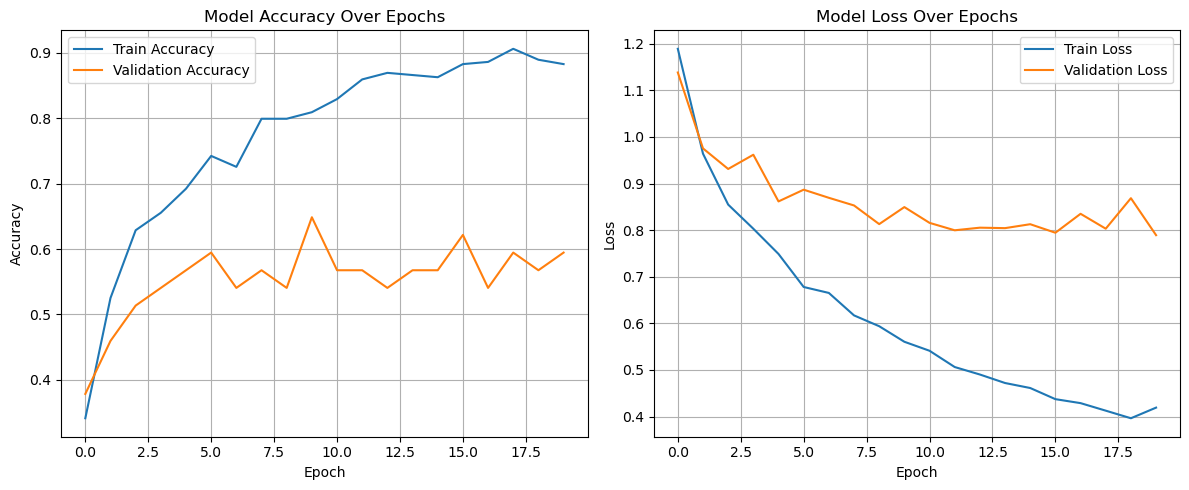

In [16]:
plot_accuracy_loss(inceptionV3_history)

#### Unfreeze and Fine-Tuning

In [17]:
inceptionV3_base_model.trainable = True
for layer in inceptionV3_base_model.layers[:-50]:
    layer.trainable = False

In [18]:
inceptionV3_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [19]:
inceptionV3_model.compile(loss = 'sparse_categorical_crossentropy',
                          optimizer = Adam(learning_rate = 0.0001),
                          metrics = ['accuracy'])

In [20]:
callbacks = [ModelCheckpoint('best_model.h5', monitor = 'val_accuracy', save_best_only = True, verbose = 1),
             ReduceLROnPlateau(monitor = 'val_accuracy', patience = 4, factor = 0.1, verbose = 1, min_lr = 1e-6),
             EarlyStopping(monitor = 'val_accuracy', patience = 5, verbose = 1)]

In [21]:
inceptionV3_history_fine = inceptionV3_model.fit(X_train, y_train, epochs = EPOCHS * 2, initial_epoch = EPOCHS, validation_data = (X_val, y_val))

Epoch 21/40
10/10 [==============================] - 7s 319ms/step - loss: 0.7094 - accuracy: 0.7057 - val_loss: 0.8314 - val_accuracy: 0.6757
Epoch 22/40
10/10 [==============================] - 2s 194ms/step - loss: 0.2036 - accuracy: 0.9498 - val_loss: 0.9397 - val_accuracy: 0.5676
Epoch 23/40
10/10 [==============================] - 2s 193ms/step - loss: 0.0571 - accuracy: 1.0000 - val_loss: 1.0513 - val_accuracy: 0.5676
Epoch 24/40
10/10 [==============================] - 2s 192ms/step - loss: 0.0404 - accuracy: 0.9866 - val_loss: 1.0105 - val_accuracy: 0.5405
Epoch 25/40
10/10 [==============================] - 2s 192ms/step - loss: 0.0200 - accuracy: 1.0000 - val_loss: 1.0032 - val_accuracy: 0.6486
Epoch 26/40
10/10 [==============================] - 2s 189ms/step - loss: 0.0174 - accuracy: 0.9967 - val_loss: 0.8627 - val_accuracy: 0.5946
Epoch 27/40
10/10 [==============================] - 2s 190ms/step - loss: 0.0138 - accuracy: 0.9967 - val_loss: 0.8329 - val_accuracy: 0.5946

In [22]:
acc += inceptionV3_history_fine.history['accuracy']
val_acc += inceptionV3_history_fine.history['val_accuracy']

loss += inceptionV3_history_fine.history['loss']
val_loss += inceptionV3_history_fine.history['val_loss']

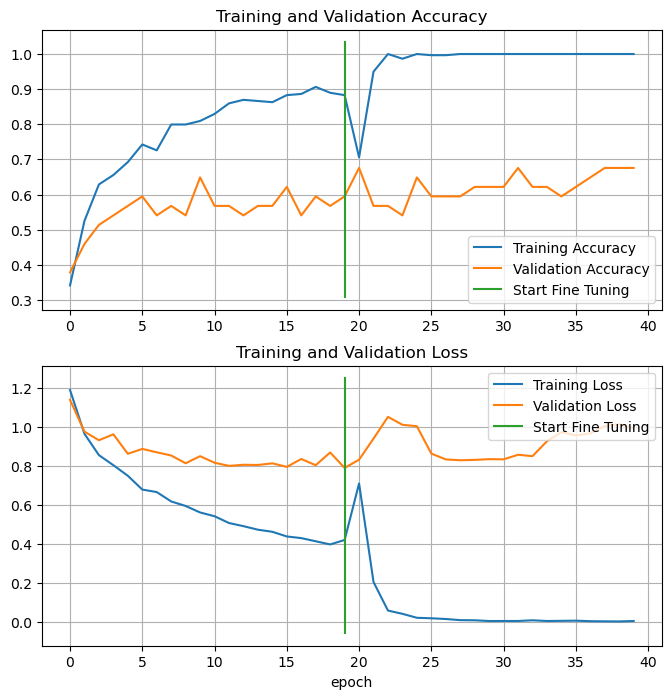

In [23]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.grid(True)
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.xlabel('epoch')
plt.show()

#### Evaluate Model

In [24]:
inceptionV3_model.evaluate(X_test, y_test)

2/2 [==============================] - 1s 325ms/step - loss: 1.4900 - accuracy: 0.6579


[1.489972710609436, 0.6578947305679321]

In [25]:
y_pred_probs = inceptionV3_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

2/2 [==============================] - 1s 171ms/step


In [26]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_names))

Classification Report:

              precision    recall  f1-score   support

         CLL       0.70      0.58      0.64        12
          FL       0.61      0.79      0.69        14
         MCL       0.70      0.58      0.64        12

    accuracy                           0.66        38
   macro avg       0.67      0.65      0.65        38
weighted avg       0.67      0.66      0.66        38



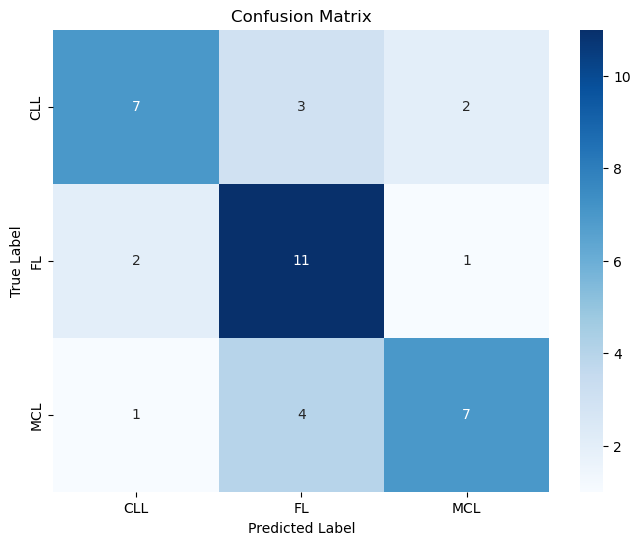

In [27]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

2/2 [==============================] - 0s 170ms/step


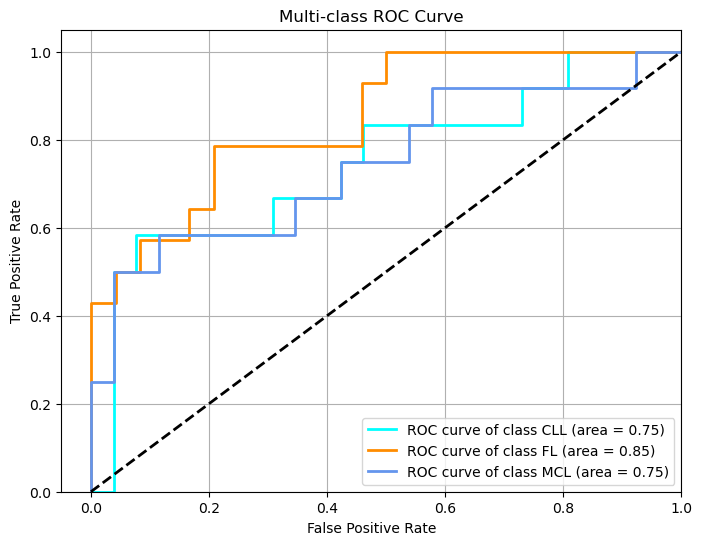

In [28]:
n_classes = len(class_names)

y_score = inceptionV3_model.predict(X_test)

y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    if np.sum(y_test_bin[:, i]) == 0:
        print(f"Skipping class {i} ({class_names[i]}): no positive samples in y_test.")
        continue
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
plt.figure(figsize=(8, 6))
for i, color in zip(roc_auc, colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### MobileNetV2

In [ ]:
mobileNetV2_base_model = MobileNetV2(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
mobileNetV2_base_model.trainable = False

#### Freeze and Feature Extraction

In [ ]:
mobileNetV2_inputs = Input(shape = (224, 224, 3))

mobileNetV2_x = tf.keras.applications.mobilenet_v2.preprocess_input(mobileNetV2_inputs)

mobileNetV2_x = mobileNetV2_base_model(mobileNetV2_x)

mobileNetV2_x = GlobalAveragePooling2D()(mobileNetV2_x)

mobileNetV2_outputs = Dense(3, activation = 'softmax')(mobileNetV2_x)

mobileNetV2_model = Model(mobileNetV2_inputs, mobileNetV2_outputs)

mobileNetV2_model.summary()

In [ ]:
len(mobileNetV2_base_model.layers)

In [ ]:
'''
tf.keras.utils.plot_model(
    mobileNetV2_model,
    to_file = 'MobileNetV2.png',
    show_shapes = True,
    show_dtype = False,
    show_layer_names = False,
    show_layer_activations = True,
    expand_nested = True
)
'''

In [ ]:
mobileNetV2_model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.001),
              metrics = ['accuracy'])

In [ ]:
mobileNetV2_history = mobileNetV2_model.fit(X_train, y_train, epochs = EPOCHS, validation_data = (X_val, y_val))

In [ ]:
plot_accuracy_loss(mobileNetV2_history)

In [ ]:
acc = mobileNetV2_history.history['accuracy']
val_acc = mobileNetV2_history.history['val_accuracy']

loss = mobileNetV2_history.history['loss']
val_loss = mobileNetV2_history.history['val_loss']

#### Unfreeze and Fine-Tuning

In [ ]:
mobileNetV2_base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(mobileNetV2_base_model.layers))

fine_tune_at = 100

for layer in mobileNetV2_base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
mobileNetV2_model.summary()

In [ ]:
len(mobileNetV2_model.trainable_variables)

In [ ]:
mobileNetV2_history = mobileNetV2_model.fit(X_train, y_train, epochs = EPOCHS + EPOCHS, initial_epoch = EPOCHS, validation_data = (X_val, y_val))

In [ ]:
acc += mobileNetV2_history.history['accuracy']
val_acc += mobileNetV2_history.history['val_accuracy']

loss += mobileNetV2_history.history['loss']
val_loss += mobileNetV2_history.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.grid(True)
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.xlabel('epoch')
plt.show()

#### Evaluate Model

In [ ]:
mobileNetV2_model.evaluate(X_test, y_test)

In [ ]:
predict_y = mobileNetV2_model.predict(X_test)

In [ ]:
predict_class = np.argmax(predict_y, axis=1)

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, predict_class)

In [ ]:
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

### EfficientNetV2B0

In [ ]:
EfficientNetV2B0_base_model = EfficientNetV2B0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
EfficientNetV2B0.trainable = False

#### Freeze and Feature Extraction

In [ ]:
EfficientNetV2B0_inputs = Input(shape = (224, 224, 3))

EfficientNetV2B0_x = tf.keras.applications.efficientnet_v2.preprocess_input(EfficientNetV2B0_inputs)

EfficientNetV2B0_x = EfficientNetV2B0_base_model(EfficientNetV2B0_x)

EfficientNetV2B0_x = GlobalAveragePooling2D()(EfficientNetV2B0_x)

# EfficientNetV2B0_x = Dropout(0.2)(EfficientNetV2B0_x)

EfficientNetV2B0_outputs = Dense(3, activation = 'softmax')(EfficientNetV2B0_x)

EfficientNetV2B0_model = Model(EfficientNetV2B0_inputs, EfficientNetV2B0_outputs)

EfficientNetV2B0_model.summary()

In [ ]:
len(EfficientNetV2B0_base_model.layers)

In [ ]:
EfficientNetV2B0_model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.001),
              metrics = ['accuracy'])

In [ ]:
EfficientNetV2B0_history = EfficientNetV2B0_model.fit(X_train, y_train, epochs = EPOCHS, validation_data = (X_val, y_val))